<a href="https://colab.research.google.com/github/iuricimatec/depthmap/blob/main/depthmap_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How do I extract depth from an image?
How do we estimate depth? Our eyes estimate depth by comparing the image obtained by our left and right eye. The minor displacement between both viewpoints is enough to calculate an approximate depth map. We call the pair of images obtained by our eyes a stereo pair.

if so, I must use 2 cameras to simulate such scenario. 
What's the left camera? and what's the right one?


References
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html

https://ez.analog.com/depth-perception-ranging-technologies/lidar-solutions/3d-tof-depth-sensing/f/q-a/561113/how-to-get-a-valid-depth-map-in-python

https://github.com/analogdevicesinc/aditof_sdk/blob/master/bindings/python/examples/first_frame/first_frame.py

https://li-chongyi.github.io/proj_SR.html


https://answers.opencv.org/question/185947/how-to-resolve-a-sadwindowsize-error/


https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f

In [ ]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


from PIL import Image

# to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
pd.set_option('display.max_columns', None)

Mounted at /content/gdrive


In [ ]:
# import dataset
df = pd.read_csv(
      '/content/gdrive/MyDrive/MCTI/Bolsa/dataset_skeleton.csv', index_col=0
)

In [ ]:
df.count()

mark1_c1_y    3762
mark2_c1_x    3760
mark2_c1_y    3760
mark3_c1_x    3735
mark3_c1_y    3735
mark4_c1_x    3452
mark4_c1_y    3452
mark1_c2_x    3762
mark1_c2_y    3762
mark2_c2_x    3760
mark2_c2_y    3760
mark3_c2_x    3757
mark3_c2_y    3757
mark4_c2_x    3701
mark4_c2_y    3701
mark1_c3_x    3762
mark1_c3_y    3762
mark2_c3_x    3749
mark2_c3_y    3749
mark3_c3_x    3704
mark3_c3_y    3704
mark4_c3_x    3459
mark4_c3_y    3459
dtype: int64

In [ ]:
# input CSV from Douglas. His code output is a CSV with tuple (x,y) for all markers. 
# how will I construct such a similar out put to match (x,y) from images and assign Z's? 
df

,mark1_c1_y,mark2_c1_x,mark2_c1_y,mark3_c1_x,mark3_c1_y,mark4_c1_x,mark4_c1_y,mark1_c2_x,mark1_c2_y,mark2_c2_x,mark2_c2_y,mark3_c2_x,mark3_c2_y,mark4_c2_x,mark4_c2_y,mark1_c3_x,mark1_c3_y,mark2_c3_x,mark2_c3_y,mark3_c3_x,mark3_c3_y,mark4_c3_x,mark4_c3_y
mark1_c1_x,,,,,,,,,,,,,,,,,,,,,,,
232,47,237.0,201.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,203.0,509.0,265,123,274.0,256.0,282.0,397.0,292.0,527.0
232,47,237.0,200.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,291.0,527.0
232,47,237.0,201.0,240.0,351.0,234.0,497.0,281,92,291.0,236.0,296.0,388.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,292.0,527.0
232,46,235.0,198.0,238.0,347.0,231.0,501.0,281,91,289.0,234.0,290.0,388.0,198.0,511.0,266,122,278.0,255.0,291.0,396.0,303.0,527.0
233,48,235.0,202.0,236.0,352.0,229.0,496.0,281,93,289.0,237.0,291.0,389.0,306.0,527.0,264,123,274.0,255.0,283.0,396.0,293.0,529.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,27,229.0,150.0,226.0,296.0,190.0,407.0,280,61,273.0,184.0,249.0,276.0,251.0,283.0,268,98,282.0,180.0,315.0,307.0,377.0,400.0
240,17,273.0,121.0,329.0,271.0,290.0,392.0,278,94,265.0,236.0,249.0,296.0,251.0,304.0,259,87,249.0,154.0,206.0,290.0,215.0,454.0
286,98,372.0,234.0,357.0,356.0,NaN,NaN,277,95,262.0,238.0,251.0,312.0,275.0,368.0,261,87,251.0,154.0,201.0,301.0,182.0,487.0


In [ ]:
# Comparing an image and its neighboor of the same camera.
# Left image paths
pathL = '/content/gdrive/MyDrive/MCTI/dataset/camera1/new/'
# Right image paths
pathR = '/content/gdrive/MyDrive/MCTI/dataset/camera2/new/'
print(os.listdir(pathL))
print(os.listdir(pathR))
# Potential fix 
# os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)

filenameL = pathL + '0021.png'
filenameR = pathR + '0021.png'

['0085.png', '1288.png', '2636.png', '3312.png', '0052.png', '1505.png', '2965.png', '2018.png', '0046.png', '1539.png', '2554.png', '2024.png', '1713.png', '1908.png', '1707.png', '1934.png', '2742.png', '0250.png', '2568.png', '2030.png', '2756.png', '1061.png', '2597.png', '3110.png', '1075.png', '3448.png', '0278.png', '0287.png', '2583.png', '3104.png', '0244.png', '1920.png', '0293.png', '2540.png', '3105.png', '2233.png', '1048.png', '1935.png', '0279.png', '0292.png', '1060.png', '2582.png', '1712.png', '1074.png', '3139.png', '2541.png', '2596.png', '3111.png', '3138.png', '2569.png', '2555.png', '1706.png', '1049.png', '2226.png', '2232.png', '2227.png', '0286.png', '2743.png', '2019.png', '2031.png', '1921.png', '0090.png', '3313.png', '1909.png', '1289.png', '3475.png', '3461.png', '1510.png', '3449.png', '0084.png', '1276.png', '3307.png', '1262.png', '1538.png', '0251.png', '0245.png', '2780.png', '2757.png', '1504.png', '2025.png', '2958.png', '2794.png', '1470.png', '29

In [ ]:
imgL = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(filenameR, cv.IMREAD_GRAYSCALE)

# print(imgL)
# print(imgR)

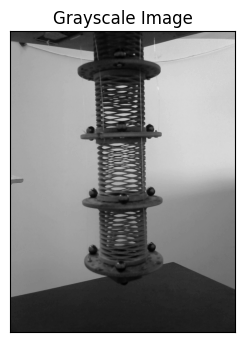

In [ ]:
# Teste de conversao RGB para grayscale 
imgL = cv.imread(filenameL)
grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
plt.subplot(122),plt.imshow(grayL, cmap = 'gray')
plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
plt.show()

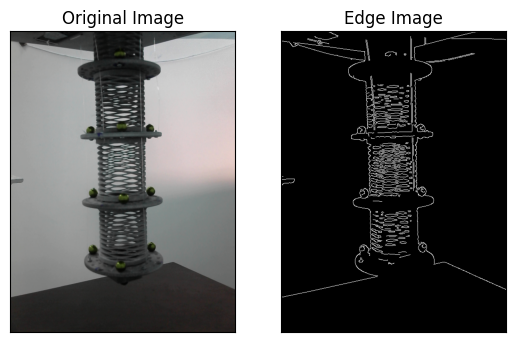

In [ ]:
##
# reading from RGB we miss central markers!
##
edges = cv.Canny(imgL,100,200)
plt.subplot(121),plt.imshow(imgL,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

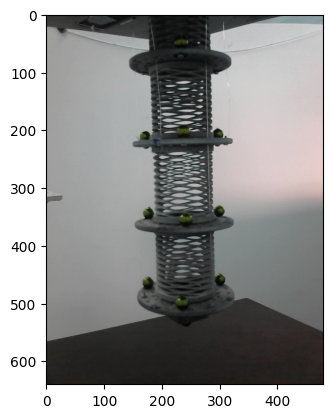

In [ ]:
# displaying grascale image
plt.imshow(imgL)
plt.show()

In [ ]:
# reading images in the RGB system, it returns an error in the procedure, which returns disparity.
imgL = cv.imread(filenameL)
imgR = cv.imread(filenameR)

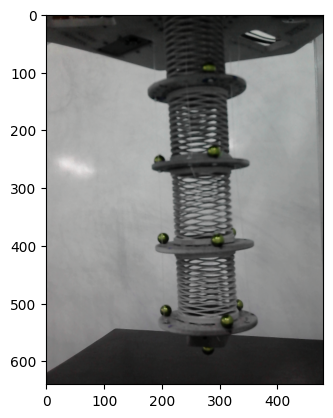

In [ ]:
plt.imshow(imgR)
plt.show()

In [ ]:
filenameL = '/content/gdrive/MyDrive/MCTI/Bolsa/RGB/0021.png'
filenameR = '/content/gdrive/MyDrive/MCTI/Bolsa/RGB/0022.png'
# saving rgb image file
cv.imwrite(filenameL,imgL)
cv.imwrite(filenameR,imgR)

True

In [ ]:
# Converting to CMYK system
# https://stackoverflow.com/questions/69955216/convert-image-to-cmyk-and-split-the-channels-in-opencv
bgrdash_L = imgL.astype(float)/255.
K_l = 1 - np.max(bgrdash_L, axis=2)
C_l = (1-bgrdash_L[...,2] - K_l)/(1-K_l)
M_l = (1-bgrdash_L[...,1] - K_l)/(1-K_l)
Y_l = (1-bgrdash_L[...,0] - K_l)/(1-K_l)
CMYK_L = (np.dstack((C_l,M_l,Y_l,K_l)) * 255).astype(np.uint8)

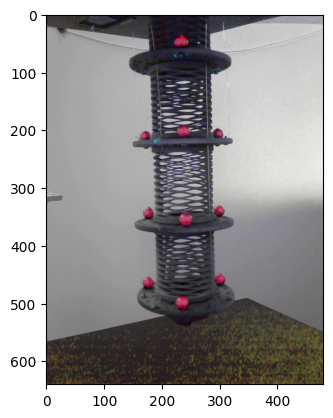

In [ ]:
# applied CMKY standard to left image
plt.imshow(CMYK_L)
plt.show()

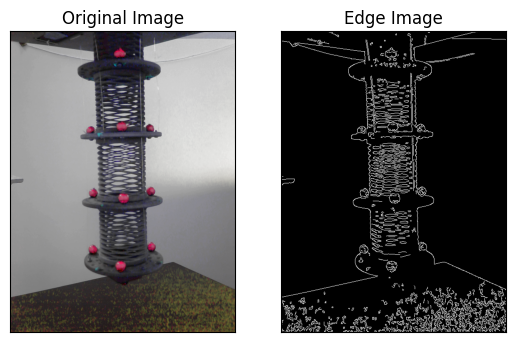

In [ ]:
###
# Canny
# we got improvement with Canny applied in the CMYK system
###
edges = cv.Canny(CMYK_L,100,200)
plt.subplot(121),plt.imshow(CMYK_L,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
bgrdash_R = imgR.astype(float)/255.
K_r = 1 - np.max(bgrdash_R, axis=2)
C_r = (1-bgrdash_R[...,2] - K_r)/(1-K_r)
M_r = (1-bgrdash_R[...,1] - K_r)/(1-K_r)
Y_r = (1-bgrdash_R[...,0] - K_r)/(1-K_r)
CMYK_R = (np.dstack((C_r,M_r,Y_r,K_r)) * 255).astype(np.uint8)


<ipython-input-18-0ffb67f121e9>:3: RuntimeWarning: invalid value encountered in true_divide
  C_r = (1-bgrdash_R[...,2] - K_r)/(1-K_r)
<ipython-input-18-0ffb67f121e9>:4: RuntimeWarning: invalid value encountered in true_divide
  M_r = (1-bgrdash_R[...,1] - K_r)/(1-K_r)
<ipython-input-18-0ffb67f121e9>:5: RuntimeWarning: invalid value encountered in true_divide
  Y_r = (1-bgrdash_R[...,0] - K_r)/(1-K_r)


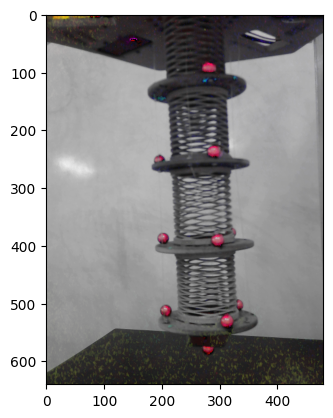

In [ ]:
# applied CMKY standard to right image 
plt.imshow(CMYK_R)
plt.show()

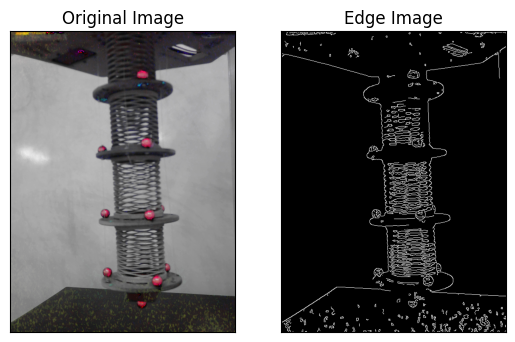

In [ ]:
###
# Canny
# we got improvement with Canny applied in the CMYK system
###
edges = cv.Canny(CMYK_R,100,200)
plt.subplot(121),plt.imshow(CMYK_R,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# create a model to sterelize images
# # https://learnopencv.com/depth-perception-using-stereo-camera-python-c/   
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
print(stereo)

< cv2.StereoBM 0x7f4e485bd590>


In [ ]:
# VErificr este metodo!!
# https://albertarmea.com/post/opencv-stereo-camera/
import sys 
calibration = np.load(filenameL, allow_pickle=True)
imageSize = tuple(calibration["imageSize"])
leftMapX = calibration["leftMapX"]
leftMapY = calibration["leftMapY"]
leftROI = tuple(calibration["leftROI"])
rightMapX = calibration["rightMapX"]
rightMapY = calibration["rightMapY"]
rightROI = tuple(calibration["rightROI"])

UnpicklingError: ignored

In [ ]:
stereoMatcher = cv2.StereoBM_create()

fixedLeft = cv2.remap(imgL, leftMapX, leftMapY, REMAP_INTERPOLATION)
fixedRight = cv2.remap(imgR, rightMapX, rightMapY, REMAP_INTERPOLATION)

grayLeft = cv2.cvtColor(fixedLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(fixedRight, cv2.COLOR_BGR2GRAY)
depth = stereoMatcher.compute(grayLeft, grayRight)


In [ ]:
 cv.cvtColor(imgL, imgL_gray, cv.COLOR_BGR2GRAY)


NameError: ignored

In [ ]:
disparity = stereo.compute(CMYK_L, CMYK_R)
print(disparity.size)
print(disparity.shape)
print(disparity)


error: ignored

In [ ]:
disparity = stereo.compute(imgL, imgR)
print(disparity.size)
print(disparity.shape)
print(disparity)


307200
(640, 480)
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


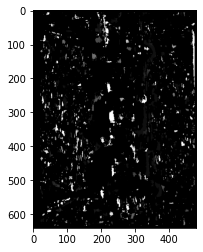

In [ ]:
plt.imshow(disparity,'gray')
# plt.imshow(disparity)
plt.show()

In [ ]:
from PIL import Image

imgGray_l = CMYK_L.convert('L')
imgGray_r = CMYK_R.convert('L')

AttributeError: ignored

In [ ]:
from PIL import Image
import numpy

for mode in ("1", "L", "LA", "I", "F", "P", "RGB", "RGBX", "RGBA", "CMYK", "YCbCr", "LAB", "HSV", "I;16"):
    typ_extra = Image._MODE_CONV[mode]
    a = numpy.array(Image.new(mode, (1, 1)))
    #a = numpy.array(Image.new(mode, (0, 0)))
    typ_extra_from_public_api = (a.dtype.str, None if a.ndim < 3 else a.shape[2])

    assert typ_extra_from_public_api == typ_extra


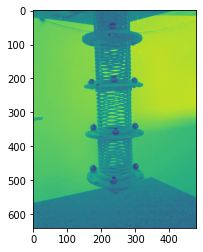

In [ ]:
# new functions to convert RGB to CMYK and vice-versa

# REference  https://stackoverflow.com/questions/14088375/how-can-i-convert-rgb-to-cmyk-and-vice-versa-in-python
RGB_SCALE = 255
CMYK_SCALE = 100
def rgb2cmyk(r, g, b):
    if (r, g, b) == (0, 0, 0):
        # black
        return 0, 0, 0, CMYK_SCALE

    # rgb [0,255] -> cmy [0,1]
    c = 1 - r / RGB_SCALE
    m = 1 - g / RGB_SCALE
    y = 1 - b / RGB_SCALE

    # extract out k [0, 1]
    min_cmy = min(c, m, y)
    c = (c - min_cmy) / (1 - min_cmy)
    m = (m - min_cmy) / (1 - min_cmy)
    y = (y - min_cmy) / (1 - min_cmy)
    k = min_cmy

    # rescale to the range [0,CMYK_SCALE]
    return c * CMYK_SCALE, m * CMYK_SCALE, y * CMYK_SCALE, k * CMYK_SCALE
    
def cmyk2rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
  r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
  g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
  b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
  return r, g, b

In [ ]:
# convert back from CMYK to RGB. Results are better if we keep image in the CMYK system. Hpwever, there's is improvement. 
R,G,B = cmyk2rgb(C_l,M_l,Y_l,K_l, CMYK_SCALE, RGB_SCALE)
# RGB_L = (np.dstack((B,G,R)) * 255).astype(np.uint8)
imgL = B+G+R
plt.imshow(imgL)
plt.show()

In [ ]:
R,G,B = cmyk2rgb(C_r,M_r,Y_r,K_r, CMYK_SCALE, RGB_SCALE)
# RGB_L = (np.dstack((B,G,R)) * 255).astype(np.uint8)
imgR = B+G+R
plt.imshow(imgR)
plt.show()

In [ ]:
from PIL import Image
imgData = np.frombuffer(CMYK_L.tobytes(), dtype='B')
invData = np.full(imgData.shape, 255, dtype='B')
invData -= imgData
imgL = Image.frombytes(imgL.mode, imgL.size, invData.tobytes())
plt.imshow(imgL)
plt.show()

# Soltion  https://holypython.com/python-pil-tutorial/color-modes-explained-for-digital-image-processing-in-python-pil/

AttributeError: ignored

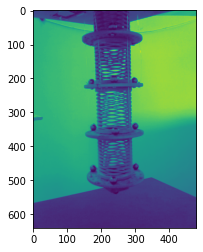

In [ ]:
# https://stackoverflow.com/questions/15026409/grayscale-cmyk-pixel
# Converting CMYK to RGB is cheap according to the formulas in http://www.easyrgb.com/index.php?X=MATH, 
# and then you can convert to grayscale using well known approaches. Supposing the c, m, y, and k in range [0, 1], we can convert it to grayscale luma as in:

def cmyk2gray(c, m, y, k):
    c = c * (1 - k) + k
    m = m * (1 - k) + k
    y = y * (1 - k) + k

    r, g, b = (1 - c), (1 - m), (1 - y)
    y = 0.299 * r + 0.587 * g + 0.114 * b
    return y

grayL = cmyk2gray(C,M,Y,K)
plt.imshow(grayL)
plt.show()

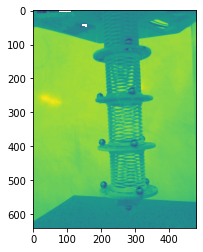

In [ ]:

R,G,B = cmyk2rgb(C,M,Y,K, CMYK_SCALE, RGB_SCALE)
# RGB_L = (np.dstack((B,G,R)) * 255).astype(np.uint8)
imgR = B+G+R
plt.imshow(imgR)
plt.show()

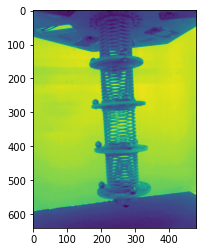

In [ ]:
grayR = cmyk2gray(C,M,Y,K)
plt.imshow(grayR)
plt.show()

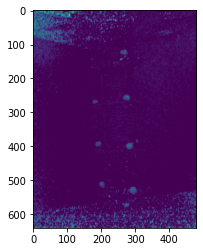

In [ ]:
# Use the cvtColor() function to grayscale the image
grayL = cv.cvtColor(CMYK_L, cv.COLOR_BGR2GRAY)
grayR = cv.cvtColor(CMYK_R, cv.COLOR_BGR2GRAY)
plt.imshow(grayR)
plt.show()

In [ ]:
# convert function must be CMYK2GRAY

In [ ]:
# saving CMYK image file
filenameL = '/content/gdrive/MyDrive/MCTI/Bolsa/CMYK/0021.png'
filenameR = '/content/gdrive/MyDrive/MCTI/Bolsa/CMYK/0022.png'
cv.imwrite(filenameL,CMYK_L)
cv.imwrite(filenameR,CMYK_R)

True

In [ ]:
imgL = cv.imread(filenameL)
imgR = cv.imread(filenameR)

In [ ]:
imgL = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(filenameR, cv.IMREAD_GRAYSCALE)

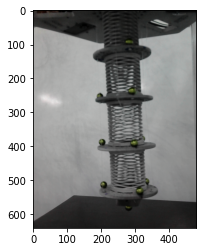

In [ ]:
plt.imshow(imgR)
plt.show()

In [ ]:
if CMYK_L == 'None' or CMYK_R == 'None':
  print("Image's empty!")
  print("Shapes: ", CMYK_L.shape, CMYK_R.shape)


<ipython-input-39-8496d3840cd6>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if CMYK_L == 'None' or CMYK_R == 'None':


In [ ]:
CMYK_L.size

1228800

In [ ]:
# imgR's shape has 3 dimensions, it must be 2 dimensions
# how would it be convert from (640, 480, 3) to (x, y)
CMYK_L.shape

(640, 480, 4)

In [ ]:
if imgL == 'None' or imgR == 'None':
  print("Image's empty!")
  print("Shapes: ", imgL.shape, imgR.shape)


<ipython-input-72-15ee6467e16e>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if imgL == 'None' or imgR == 'None':


In [ ]:
# imgR

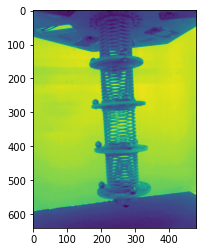

In [ ]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
print(stereo)

< cv2.StereoBM 0x7f5208befa10>


In [ ]:
# The definition of disparity is the distance between two comparable pixels in the left and right images. 
# However, by running the following code, I obtained a map with the same size as the input photos with values ranging from -16 to 211
disparity = stereo.compute(grayL, grayR)
print(disparity.size)
print(disparity.shape)
print(disparity)

NameError: ignored

In [ ]:
disparity = stereo.compute(CMYK_L, CMYK_R)
print(disparity.size)
print(disparity.shape)
print(disparity)

error: ignored

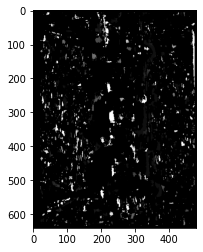

In [ ]:
plt.imshow(disparity,'gray')
# plt.imshow(disparity)
plt.show()

In [ ]:
# Disparity from Cameras 1 and 3

In [ ]:
print(disparity)

[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


In [ ]:
# Left image paths
pathL = '/content/gdrive/MyDrive/MCTI/dataset/camera1/new/'
# Right image paths
pathR = '/content/gdrive/MyDrive/MCTI/dataset/camera3/new/'
print(os.listdir(pathL))
print(os.listdir(pathR))

# Potential fix 
# os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)

filenameL = pathL + '0001.png'
filenameR = pathR + '0001.png'

['0085.png', '1288.png', '2636.png', '3312.png', '0052.png', '1505.png', '2965.png', '2018.png', '0046.png', '1539.png', '2554.png', '2024.png', '1713.png', '1908.png', '1707.png', '1934.png', '2742.png', '0250.png', '2568.png', '2030.png', '2756.png', '1061.png', '2597.png', '3110.png', '1075.png', '3448.png', '0278.png', '0287.png', '2583.png', '3104.png', '0244.png', '1920.png', '0293.png', '2540.png', '3105.png', '2233.png', '1048.png', '1935.png', '0279.png', '0292.png', '1060.png', '2582.png', '1712.png', '1074.png', '3139.png', '2541.png', '2596.png', '3111.png', '3138.png', '2569.png', '2555.png', '1706.png', '1049.png', '2226.png', '2232.png', '2227.png', '0286.png', '2743.png', '2019.png', '2031.png', '1921.png', '0090.png', '3313.png', '1909.png', '1289.png', '3475.png', '3461.png', '1510.png', '3449.png', '0084.png', '1276.png', '3307.png', '1262.png', '1538.png', '0251.png', '0245.png', '2780.png', '2757.png', '1504.png', '2025.png', '2958.png', '2794.png', '1470.png', '29

In [ ]:
imgL = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(filenameR, cv.IMREAD_GRAYSCALE)

print(imgL)
# print(imgR)



[[ 54  54  56 ... 169 165 171]
 [ 57  55  56 ... 168 173 172]
 [ 59  56  55 ... 169 169 170]
 ...
 [ 30  31  30 ...  29  27  26]
 [ 30  30  30 ...  28  27  25]
 [ 31  31  31 ...  29  27  25]]


In [ ]:
# cv.imshow(window_name, imgL)
# cv.imshow(window_name, imgR)
if imgL == 'None' or imgR == 'None':
  print("Image's empty!")
  print("Shapes: ", imgL.shape, imgR.shape)


<ipython-input-39-5b1ad68629a6>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if imgL == 'None' or imgR == 'None':


In [ ]:
disparity = stereo.compute(imgL,imgR)
print(disparity.size)
print(disparity.shape)
print(disparity)

error: ignored

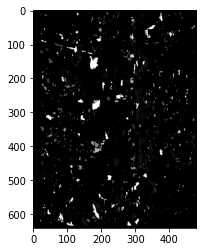

In [ ]:
plt.imshow(disparity,'gray')
# plt.imshow(disparity)
plt.show()